# Numpy Tutorial (Advanced)

**Note:**
1. Mandatory pre-requisite execution: Numpy Tutorial Notebook
2. Numpy Documentation - User Guide & API Reference: https://numpy.org/doc/stable/
3. Cautionary Note: Watch out for the version of numpy you are using and the documentation you are referring

## Table of Contents

**Calculating farthest patients in a dataset**

1. [Traditional approach](#single-dataset-traditional-approach)
2. [Fancy Indexing](#fancy-indexing)
3. [Vectorization with brute force matrix row permutation](#bruteforce-vectorization)
4. [Digression: meshgrid and linspace](#meshgrid)
5. [Vectorization with meshgrid](#meshgrid-vectorization)
6. [Vectorization with triu_indices](#triu-vectorization)


**Pairwise distance between two different set of points**

1. [Traditional Approach](#traditional-two)
2. [Direct matrix subtraction](#direct-matrix-subtract)
2. [Brute force combination of two datasets](#bruteforce-vectorization-2)

**Tensors**
1. [Different types of visualization](#tensor-viz)
2. [Creating Tensors](#create-tensor)
3. [Accessing tensor elements and reshaping tensor](#access-elements)
4. [Broadcasting by expanding dimension](#broadcast-expand)
5. [Materializing a 2D broadcast over 3D tensor with a concrete full example](#materialize)
6. [Broadcasting 2D array over tensor](#tensor-broadcast)
7. [Expand and Reduce Strategy](expand-reduce)
8. [Matrix product formula based approach - TBD](#for-future)

In [1]:
import random 

import numpy as np
import pandas as pd

<a id='single-dataset-traditional-approach'></a>
<hr/>

## Calculating farthest patients in a dataset

### 1. Traditional Approach

In [2]:
df_patient = pd.DataFrame({'HR' : [76, 74, 72, 78],
                           'BP' : [126, 120, 118, 136],
                           'Temp': [38, 38, 37.5, 37]})

print(df_patient)
patients = np.array(df_patient)
patients

   HR   BP  Temp
0  76  126  38.0
1  74  120  38.0
2  72  118  37.5
3  78  136  37.0


array([[ 76. , 126. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 72. , 118. ,  37.5],
       [ 78. , 136. ,  37. ]])

In [3]:
num_patients = patients.shape[0]

farthest_patient_tuple_index = None
farthest_distance_so_far = 0

for i in range (0,num_patients):
    for j in range (0,num_patients):
        if i==j:
            pass
        dist = np.linalg.norm(patients[i] - patients[j])  #linalg.norm-> dist=np.sqrt(np.sum(a-b)**2)
        if dist > farthest_distance_so_far:
            farthest_distance_so_far = dist
            farthest_patient_tuple_index = (i, j)

Add Random values to the dataset

In [13]:
num_add = 100

random_HR = np.random.randint(60, 80, size=num_add)
random_BP = np.random.randint(110, 150, size=num_add)
random_Temp = np.random.randint(35, 45, size=num_add)

random_data = pd.DataFrame({'HR': random_HR, 'BP': random_BP, 'Temp': random_Temp})

df_patient = pd.concat([df_patient, random_data], ignore_index=True)

print(df_patient.head(20))

    HR   BP  Temp
0   76  126  38.0
1   74  120  38.0
2   72  118  37.5
3   78  136  37.0
4   62  127  37.0
5   65  136  43.0
6   72  146  43.0
7   79  143  35.0
8   67  116  43.0
9   67  124  42.0
10  61  119  39.0
11  71  140  37.0
12  70  138  39.0
13  72  133  44.0
14  68  143  44.0
15  61  123  44.0
16  61  111  40.0
17  79  148  35.0
18  73  125  44.0
19  67  113  40.0


In [16]:
print(f'Farthest patients are patient-{farthest_patient_tuple_index[0]} and patient-{farthest_patient_tuple_index[1]}')

Farthest patients are patient-2 and patient-3


<a id='fancy-indexing'></a>
<hr/>

### 2. Fancy Indexing

Fancy indexing means passing an array of indices to access multiple array elements at once

##### 2.1 From Indexing to Fancy Indexing - Let's do a indexing experiment

In [18]:
arr = np.arange(10, 18)
arr

array([10, 11, 12, 13, 14, 15, 16, 17])

In [19]:
inputNumbers =range(0,100)
sampled_numbers = random.sample(inputNumbers, 16)
sampled_numbers

[85, 68, 37, 39, 34, 81, 97, 30, 38, 1, 59, 35, 62, 13, 52, 9]

In [23]:
X = np.array(sampled_numbers).reshape(4, -1)
X

array([[85, 68, 37, 39],
       [34, 81, 97, 30],
       [38,  1, 59, 35],
       [62, 13, 52,  9]])

In [24]:
X[3,1] # this is regular indexing that we have learnt till now

13

In [25]:
X[(3,1)] #providing the index as a tuple works same as earlier

13

In [26]:
X[[(3,1),(2,2)]] #Something seems off this kind of access. Let's forget this

array([[[62, 13, 52,  9],
        [34, 81, 97, 30]],

       [[38,  1, 59, 35],
        [38,  1, 59, 35]]])

In [27]:
print(X) #print X for reference

#Let us reverse the tuple and list symbols from previous
X[([3,1],[2,2])] # observe that the elements selected have indices (3,2) and (1,2)

[[85 68 37 39]
 [34 81 97 30]
 [38  1 59 35]
 [62 13 52  9]]


array([52, 97])

In [28]:
#  Same as previous
X[[3,1],[2,2]] # Getting rid of the tuple sign has no impact on the selection.

array([52, 97])

##### 2.2 Most important take away of this section

In [29]:
print(X) #print X a reference

print("")
print(X[[3,1,1]]) # entire rows are selected when a single list of numbers provided as index 

[[85 68 37 39]
 [34 81 97 30]
 [38  1 59 35]
 [62 13 52  9]]

[[62 13 52  9]
 [34 81 97 30]
 [34 81 97 30]]


<a id='bruteforce-vectorization'></a>
<hr/>

### 3. Vectorization with brute force matrix row permutation

##### 3.1 Two patient matrices with different indices

Create a matrix with ONLY Patient 0 data
$$
\begin{bmatrix}  76 & 126 & 38 \\ 76 & 126 & 38 \\ 76 & 126 & 38 \\ 76 & 126 & 38  \end{bmatrix} 
$$

In [30]:
patients[[0,0,0,0]] # this is not duplicating data, only maintaining reference to original np array

array([[ 76., 126.,  38.],
       [ 76., 126.,  38.],
       [ 76., 126.,  38.],
       [ 76., 126.,  38.]])

Take the matrix with all patient data
$$
\begin{bmatrix}  76 & 126 & 38 \\ 74 & 120 & 38 \\ 72 & 118 & 37.5 \\ 78 & 136 & 37  \end{bmatrix} 
$$

In [33]:
patients[[0,1,2,3]] # this is also not duplicating data, only maintaining reference to original np array

patients

array([[ 76. , 126. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 72. , 118. ,  37.5],
       [ 78. , 136. ,  37. ]])

$$ 
\begin{bmatrix}  76 & 126 & 38 \\ 76 & 126 & 38 \\ 76 & 126 & 38 \\ 76 & 126 & 38  \end{bmatrix} 
-
\begin{bmatrix}  76 & 126 & 38 \\ 74 & 120 & 38 \\ 72 & 118 & 37.5 \\ 78 & 136 & 37  \end{bmatrix} 

$$

In [35]:
# Will this patient diff calculate the pairwise distance for all patients? 
patient_diffs = patients[[0,0,0,0]] - patients[[0,1,2,3]]
patient_diffs 

array([[  0. ,   0. ,   0. ],
       [  2. ,   6. ,   0. ],
       [  4. ,   8. ,   0.5],
       [ -2. , -10. ,   1. ]])

The code below gives us the distance of all patients from patient 0 and finds the max

In [36]:
np.linalg.norm(patient_diffs, axis=1)

array([ 0.        ,  6.32455532,  8.95823643, 10.24695077])

In [37]:
np.argmax(np.linalg.norm(patient_diffs, axis=1))

3

#### 3.2 Building two patient matrices for pairwise distance calculation

1. How about we create two lists with row index permutations?
2. This brute force method works!!

In [38]:
idx0 = np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3])
idx1 = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])

patient_diffs = patients[idx0]-patients[idx1]
maxdist_idx = np.argmax(np.linalg.norm(patient_diffs, axis=1))
print(f"patients farthest are {(idx0[11], idx1[11])}")

patients farthest are (2, 3)


In [39]:
patients[idx0]

array([[ 76. , 126. ,  38. ],
       [ 76. , 126. ,  38. ],
       [ 76. , 126. ,  38. ],
       [ 76. , 126. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 72. , 118. ,  37.5],
       [ 72. , 118. ,  37.5],
       [ 72. , 118. ,  37.5],
       [ 72. , 118. ,  37.5],
       [ 78. , 136. ,  37. ],
       [ 78. , 136. ,  37. ],
       [ 78. , 136. ,  37. ],
       [ 78. , 136. ,  37. ]])

In [40]:
patients[idx1]

array([[ 76. , 126. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 72. , 118. ,  37.5],
       [ 78. , 136. ,  37. ],
       [ 76. , 126. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 72. , 118. ,  37.5],
       [ 78. , 136. ,  37. ],
       [ 76. , 126. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 72. , 118. ,  37.5],
       [ 78. , 136. ,  37. ],
       [ 76. , 126. ,  38. ],
       [ 74. , 120. ,  38. ],
       [ 72. , 118. ,  37.5],
       [ 78. , 136. ,  37. ]])

Shortcomings of the above method: 

1. Hardcoded indices
2. Calculation of distance between two points (a,b) is is same as distance between (b,a). Wasteful repetitive calculation
3. Calculation of distance from self is always zero and wasteful calculation

<a id='meshgrid'></a>
<hr/>

In [ ]:
patient_diffs = patients[idx0]-patients[idx1]
maxdist_idx = np.argmax(np.linalg.norm(patient_diffs, axis=1))
print(f"patients farthest are {(idx0[11], idx1[11])}")

### 4. Digression: meshgrid and linspace

In [41]:
points = np.arange(0,4)
points

array([0, 1, 2, 3])

In [45]:
np.meshgrid(points,points)




[array([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]]),
 array([[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])]

![meshgrid](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211909&authkey=%21AAuRGlspEJ3R79U&width=500)

##### 4.1 meshgrid for function evaluation over coordinate space & function plotting

In combination with linspace

In [46]:
def my_func(x, y):
    return np.sin(4 * x) + np.cos(4 * y)

In [47]:
np.linspace(-10, 10, 100)

array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818,  -7.97979798,  -7.77777778,
        -7.57575758,  -7.37373737,  -7.17171717,  -6.96969697,
        -6.76767677,  -6.56565657,  -6.36363636,  -6.16161616,
        -5.95959596,  -5.75757576,  -5.55555556,  -5.35353535,
        -5.15151515,  -4.94949495,  -4.74747475,  -4.54545455,
        -4.34343434,  -4.14141414,  -3.93939394,  -3.73737374,
        -3.53535354,  -3.33333333,  -3.13131313,  -2.92929293,
        -2.72727273,  -2.52525253,  -2.32323232,  -2.12121212,
        -1.91919192,  -1.71717172,  -1.51515152,  -1.31313131,
        -1.11111111,  -0.90909091,  -0.70707071,  -0.50505051,
        -0.3030303 ,  -0.1010101 ,   0.1010101 ,   0.3030303 ,
         0.50505051,   0.70707071,   0.90909091,   1.11111111,
         1.31313131,   1.51515152,   1.71717172,   1.91919192,
         2.12121212,   2.32323232,   2.52525253,   2.72

In [50]:
XX, YY = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))

print(type(XX))

ZZ = my_func(XX, YY) #do you notice this is vectorized operation?

<class 'numpy.ndarray'>


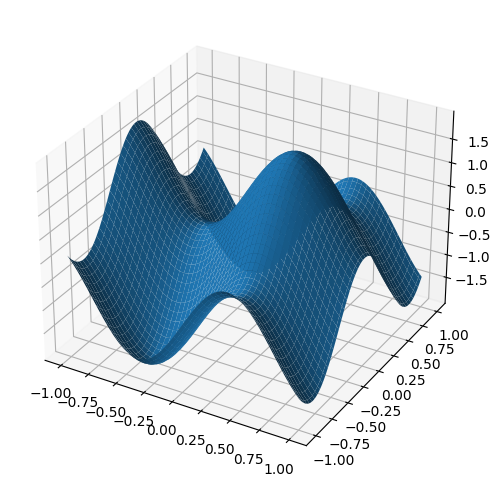

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111, projection='3d')
cmap='viridis'

ax.plot_surface(XX,YY,ZZ)
plt.show()

<a id='meshgrid-vectorization'></a>
<hr/>

### 5. Automated vectorization with meshgrid

In [51]:
points = np.arange(0,4)
idx1, idx0 = np.meshgrid(points,points)
print(idx0)
print(idx1)

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]]
[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]


In [52]:
idx0 = idx0.flatten()
idx1 = idx1.flatten()
print(idx0)
print(idx1)

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]


In [60]:
arg_max = np.argmax(np.linalg.norm(diff, axis=1))
arg_max

11

In [62]:
# TODO: Fill this space to calculate the pairwise max distance without looking back
# .... patients[idx0] - patients[idx1] ....

diff = patients[idx0] - patients[idx1]
max_distance = np.argmax(np.linalg.norm(diff, axis=1))
print('Farthest patients are', idx0[max_distance], 'and', idx1[max_distance])


Farthest patients are 2 and 3


Observations: We still have two problems left

1. Calculation of distance between two points (a,b) is is same as distance between (b,a). Wasteful repetitive calculation
2. Calculation of distance from self is always zero and wasteful calculation

<a id='triu-vectorization'></a>
<hr/>

### 6. Vectorization with triu_indices

##### 6.1 Eliminate redundant (a,b) and (b,a) distance calc (and have some fun with array indices)

In [63]:
X #print for reference

array([[85, 68, 37, 39],
       [34, 81, 97, 30],
       [38,  1, 59, 35],
       [62, 13, 52,  9]])

In [64]:
indices = np.triu_indices(4) # A strangely funny name for a numpy function. Hmm.. I wonder what is it? 
indices

(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([0, 1, 2, 3, 1, 2, 3, 2, 3, 3]))

In [65]:
print(f"type(indices)={type(indices)}")
print(f"len(indices)={len(indices)}")

type(indices)=<class 'tuple'>
len(indices)=2


In [66]:
idx0, idx1 = indices #Unpack the tuples
print(idx0)
print(idx1)

[0 0 0 0 1 1 1 2 2 3]
[0 1 2 3 1 2 3 2 3 3]


In [67]:
print(X)
print(X[idx0, idx1]) # Selecting X elements using both indices. Can you explain what is special about the selection?

[[85 68 37 39]
 [34 81 97 30]
 [38  1 59 35]
 [62 13 52  9]]
[85 68 37 39 81 97 30 59 35  9]


In [68]:
np.hstack(
    (
        idx0.reshape(-1,1), idx1.reshape(-1,1)
    )
) #Indices you see here are the patients that will be compared. Do you see (a,b) and (b,a) duplication is gone?

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 2],
       [2, 3],
       [3, 3]])

In [ ]:
# TODO: Fill code here to 
# create two patient matrices using idx0 and idx1, 
# find their difference and get the distance, find argmax  




Observations: We still have two problems left

1. Calculation of distance from self is always zero and wasteful calculation

We will fix this now

##### 6.2 triu_indices and k right shift

In [69]:
idx0, idx1 = np.triu_indices(4, k=1)
idx0, idx1

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))

In [70]:
X = np.array(sampled_numbers).reshape(4,-1)
X

array([[85, 68, 37, 39],
       [34, 81, 97, 30],
       [38,  1, 59, 35],
       [62, 13, 52,  9]])

In [71]:
X[idx0, idx1] #what special pattern do you see in matrix elements selected here?

array([68, 37, 39, 97, 30, 35])

In [72]:
np.hstack(
    (
        idx0.reshape(-1,1), idx1.reshape(-1,1)
    )
) #Indices you see here are the patients that will be compared. Do you see self distance calc is gone?

array([[0, 1],
       [0, 2],
       [0, 3],
       [1, 2],
       [1, 3],
       [2, 3]])

In [74]:
# TODO: Fill code here to 
# create two patient matrices using idx0 and idx1, 
# find their difference and get the distance, find argmax  

diff = patients[idx0] - patients[idx1]
arg_max = np.argmax(np.linalg.norm(diff, axis= 1))
arg_max


5

##### 1.6 Practice Problems

1. Use scipy.spatial.distance.pdist to do this exact calc in one line function call. Compare and contrast with cdist in scipy
2. Use sklearn.metrics.pairwise_distances to do this exact calc in one line function call

NOTE: sklearn has an entire <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise">module</a> dedicated to pairwise calc

<hr/>

## Pairwise distance between two different set of points

In [30]:
import pandas as pd

In [31]:
df_patient1 = pd.DataFrame({'HR' : [76, 74, 72, 78, 77, 76, 75, 73],
                           'BP' : [126, 120, 118, 136, 122, 127, 125, 130],
                           'Temp': [38, 38, 37.5, 37, 39, 28, 37.5, 37]})

print(df_patient1)
patients1 = df_patient1.to_numpy()

   HR   BP  Temp
0  76  126  38.0
1  74  120  38.0
2  72  118  37.5
3  78  136  37.0
4  77  122  39.0
5  76  127  28.0
6  75  125  37.5
7  73  130  37.0


In [82]:

print(patients1, '\n')
print('\n', patients2)

[[ 76.  126.   38. ]
 [ 74.  120.   38. ]
 [ 72.  118.   37.5]
 [ 78.  136.   37. ]
 [ 77.  122.   39. ]
 [ 76.  127.   28. ]
 [ 75.  125.   37.5]
 [ 73.  130.   37. ]] 


 [[ 77.  132.   37. ]
 [ 79.  118.   39. ]
 [ 71.  123.   38.5]
 [ 74.  131.   36. ]
 [ 77.  121.   39.5]]


In [32]:
df_patient2 = pd.DataFrame({'HR' : [77, 79, 71, 74, 77],
                           'BP' : [132, 118, 123, 131, 121],
                           'Temp': [37, 39, 38.5, 36, 39.5]})

print(df_patient2)
patients2 = df_patient2.to_numpy()

   HR   BP  Temp
0  77  132  37.0
1  79  118  39.0
2  71  123  38.5
3  74  131  36.0
4  77  121  39.5


<a id='traditional-two'></a>
<hr/>

### 1. Traditional approach

In [83]:
num_patients1 = patients1.shape[0]
num_patients2 = patients2.shape[0]

farthest_patient_tuple_index = None
farthest_distance_so_far = 0

for i in range (0,num_patients1):
    for j in range (0,num_patients2):
        if i==j:
            pass
        dist = np.linalg.norm(patients1[i] - patients2[j])
        if dist > farthest_distance_so_far:
            farthest_distance_so_far = dist
            farthest_patient_tuple_index = (i, j)

In [84]:
print(
    f'Farthest patients are patient-{farthest_patient_tuple_index[0]} ' + 
    f'and patient-{farthest_patient_tuple_index[1]}')
print(f'Distance between them is {farthest_distance_so_far}')

Farthest patients are patient-3 and patient-1
Distance between them is 18.138357147217054


<a id='direct-matrix-subtract'></a>
<hr/>

### 2. Direct matrix subtraction

In [85]:
np.linalg.norm(patients1 - patients2, axis=1) # Will this work?

ValueError: operands could not be broadcast together with shapes (8,3) (5,3) 

In [86]:
print(f"patients1.shape = {patients1.shape}")
print(f"patients2.shape = {patients2.shape}")

patients1.shape = (8, 3)
patients2.shape = (5, 3)


<a id='bruteforce-vectorization-2'></a>
<hr/>

##### 3. Brute force combination of two datasets

In [88]:
points1 = np.arange(0,8)
points2 = np.arange(0,5)
idx1, idx0 = np.meshgrid(points1,points2)
print(idx0, '\n\n')
print(idx1)

[[0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4]] 


[[0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]]


In [89]:
idx0 = idx0.flatten()
idx1 = idx1.flatten()
print(idx0)
print(idx1)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4
 4 4 4]
[0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4
 5 6 7]


In [90]:
diff_vector = patients1[idx1] - patients2[idx0]
diff_vector

array([[ -1. ,  -6. ,   1. ],
       [ -3. , -12. ,   1. ],
       [ -5. , -14. ,   0.5],
       [  1. ,   4. ,   0. ],
       [  0. , -10. ,   2. ],
       [ -1. ,  -5. ,  -9. ],
       [ -2. ,  -7. ,   0.5],
       [ -4. ,  -2. ,   0. ],
       [ -3. ,   8. ,  -1. ],
       [ -5. ,   2. ,  -1. ],
       [ -7. ,   0. ,  -1.5],
       [ -1. ,  18. ,  -2. ],
       [ -2. ,   4. ,   0. ],
       [ -3. ,   9. , -11. ],
       [ -4. ,   7. ,  -1.5],
       [ -6. ,  12. ,  -2. ],
       [  5. ,   3. ,  -0.5],
       [  3. ,  -3. ,  -0.5],
       [  1. ,  -5. ,  -1. ],
       [  7. ,  13. ,  -1.5],
       [  6. ,  -1. ,   0.5],
       [  5. ,   4. , -10.5],
       [  4. ,   2. ,  -1. ],
       [  2. ,   7. ,  -1.5],
       [  2. ,  -5. ,   2. ],
       [  0. , -11. ,   2. ],
       [ -2. , -13. ,   1.5],
       [  4. ,   5. ,   1. ],
       [  3. ,  -9. ,   3. ],
       [  2. ,  -4. ,  -8. ],
       [  1. ,  -6. ,   1.5],
       [ -1. ,  -1. ,   1. ],
       [ -1. ,   5. ,  -1.5],
       [ -

In [91]:
diff_vector.shape

(40, 3)

In [92]:
np.max(np.linalg.norm(diff_vector, axis=1))

18.138357147217054


1. The above brute force vectorization approach works, but you will see antother approach soon
2. The newer approach, although seems convoluted, is demonstrated with the aim of teaching yet another important pair of topics - Tensors and broacasting over a tensor 

<a id='tensor-viz'></a>
<hr/>

## Tensors

The following different ways of tensor visualization are helpful
1. Tensor as layer of matrices
2. Tensor as 1-D collection of immediately lower dimension tensor
3. Tensor as row ordered 2-D collection of immediately lower dimension tensor

Different visualization are helpful at different times.

### 1. Different types of visualization



1. Logical visualization of Tensors as layers of matrices

![Tensor Logical](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211908&authkey=%21ANy1yIIMk-HuYO8&width=500)


2. Logical visualization og RGB tensor as layers of matrices

This visualization helps in double broadcasting of arrays and tensors over each other together spanning a rectange or a cuboid of space producing a grand congolomeration

![RGB1](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211899&authkey=%21AEqnVdUFicVGqEA&width=400)![RGB2](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211900&authkey=%21AGfOyYF0ldG6FpU&width=500)


3. Visualization as 1-D collection lower dimension

- 1-D Vectors are 1-D collection of scalars
- 2-D Tensors are 1-D collection of 1-D Vectors
- 3-D Tensors are 1-D collection of 2-D vectors

We will use this approach initially when constructing the tensors till you are warmed up to the next type of visualization

![Mathematics](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211911&authkey=%21AACrTbARFSX0BpU&width=936&height=388)


4. Visualization as row ordered collection of lower dimension

This REALLY helps while doing high dimension tensor manipulation mathematically in numpy and is most aligned with numpy internal logical structure

![Math2](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211910&authkey=%21AMdhcQ1R9jTc-UE&width=675&height=267)

The numpy's internal logical structure of a 3-D tensor is as follows. Shown along with axis. This is also the direction of shape determination

![numpyInternal](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211903&authkey=%21AMaziDT6mdVYfPs)


<a id='create-tensor'></a>
<hr/>

### 2. Creating Tensors

In [93]:
# 2-D tensor (matrix) written as collection of 1D vectors
arr1d_1 = [1,2,3]
arr1d_2 = [4,5,6]

arr2d = np.array([arr1d_1, arr1d_2]) # watch the comman between two 1d-vectors
arr2d


array([[1, 2, 3],
       [4, 5, 6]])

In [94]:
#Create the 2d array at one shot
np.array([[1,2,3], [4,5,6]])

array([[1, 2, 3],
       [4, 5, 6]])

In [95]:
#3-D tensor of 2 x 2 x 3 written as collection of 2 2-D arrays each of 2 x 3
arr2d_1 = np.array([
                    [1,2,3],[4,5,6]
                    ])

arr2d_2 = np.array([
                    [6,5,4],[3,2,1]
                ])

arr3d = np.array([arr2d_1, arr2d_2,])
arr3d

array([[[1, 2, 3],
        [4, 5, 6]],

       [[6, 5, 4],
        [3, 2, 1]]])

In [96]:
arr3d.shape

(2, 2, 3)

In [ ]:
#create a 4D array

In [97]:
newarr = \
np.array([
    [
        [1,2,3], [4,5,6]
    ],
    [
        [6,5,4],[3,2,1]
    ]
])

In [98]:
newarr.shape

(2, 2, 3)

##### Practice Problems

1. Create a 3-D tensor of dimension 2 x 3 x 4 (Use the intuition that 3-D tensor is a collection of 2-D tensors) 
2. Create a 4-D tensor of dimension 2 x 3 x 4 x 2 (Use the intuition that 4-D tensor is a collection of 3-D tensors)

3. Create the 3D tensor shown here

![Mathematics](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211905&authkey=%21AHDgDKzqiepPZZQ&width=660)

In [103]:
## TODO: Create here now
arr_1 = np.array([1])

arr_2 = np.array([1,2])

arr2_1 = np.array([5,6])

arr_3 = np.array([arr_1, arr2_1])

C:\Users\ATISHAY SG\AppData\Local\Temp\ipykernel_19940\2550276178.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_3 = np.array([arr_1, arr2_1])


<a id='access-elements'></a>
<hr/>

### 3. Accessing tensor elements and reshaping tensor

##### 3.1 Access tensor elements

In [ ]:
arr[1,1,0]

**Walking the tensor from right to left (innermost to outermost)**

In [ ]:
x = np.array([
        [[1, 2], [3, 4], [5, 6]], 
        [[7, 8], [9, 10], [11, 12]], 
        [[13, 14], [15, 16], [17, 18]], 
        [[19, 20], [21, 22], [23, 24]]
    ])
x

In [ ]:
x.shape

![scalar](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211896&authkey=%21AFrofwtWaV2_0KI&width=256)

![scalar](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211897&authkey=%21AEmN8nBBF8GBhQk&width=256)

![scalar](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211898&authkey=%21AHsLmF_pBGdLk8c&width=519&height=337)

##### 3.2 Reshaping tensor

In [ ]:
x = np.array([
        [1, 2, 3, 4], 
        [5, 6, 7, 8], 
        [9, 10, 11, 12], 
        [13, 14, 15, 16], 
        [17, 18, 19, 20], 
        [21, 22, 23, 24]
    ])
print(x) 

In [ ]:
x.shape

In [ ]:
x.reshape((8, 3))

In [ ]:
x.reshape((12, 2))

In [ ]:
x.reshape((3, 4, 2))

In [ ]:
x.reshape((2, 11))

In [ ]:
x.reshape((2, 2, 1, 1, 2, 3))

<a id='broadcast-expand'></a>
<hr/>


### 4. Broadcasting by expanding dimension

##### 4.1 Adding a new axis

In [3]:
import numpy as np

In [4]:
a = np.arange(10)
print(a)
print(a.shape)

[0 1 2 3 4 5 6 7 8 9]
(10,)


In [5]:
b = a[:, np.newaxis] # Newaxis at end for nparray is same as reshaping as column vector
print(b)
print(b.shape)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
(10, 1)


In [6]:
c = a[np.newaxis, :] # Newaxis at beginning for nparray is same as reshaping as row vector
print(c)
print(c.shape)

[[0 1 2 3 4 5 6 7 8 9]]
(1, 10)


##### 4.2 Broadcasting review

$$\begin{bmatrix} 1 & 2 & 3\\4 & 5 & 6\end{bmatrix} + \begin{bmatrix}1 && 2 \end{bmatrix}$$

In [7]:
X = np.array([[1,2,3],[4,5,6]])
a = np.array([1,2]) #Trying broadcasting along defaul axis=0 fails due to dimension mismatch
X+a

ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

In [8]:
X = np.array([[1,2,3],[4,5,6]])
a = np.array([1,2]).reshape(-1,1) #This is how we get broadcasting along axis 1
X+a

array([[2, 3, 4],
       [6, 7, 8]])

$$
\begin{bmatrix} 1 & 2 & 3\\4 & 5 & 6\end{bmatrix} + \begin{bmatrix}1 \\ 2 \end{bmatrix} = 

\begin{bmatrix} 1 & 2 & 3\\4 & 5 & 6\end{bmatrix} + \begin{bmatrix}1 & \color{red}1 & \color{red}1 \\ 2 & \color{red}2 & \color{red}2\end{bmatrix}

$$

<br/>

**np.newaxis : Your friend in broadcasting**

In [9]:
X = np.array([[1,2,3],[4,5,6]])

a = np.array([1,2]) 
print(f"Shape of a before newaxis = {a.shape}")

a = a[:, np.newaxis] # This is doing the same thing as reshape above
print(f"Shape of a AFTER newaxis = {a.shape}")

X+a

Shape of a before newaxis = (2,)
Shape of a AFTER newaxis = (2, 1)


array([[2, 3, 4],
       [6, 7, 8]])

##### 4.3 Double broadcasting over 1-D matrix

Notice that the two respectively spanning in vertical and horizontal direction create a square/rectangular area where the broadcast operation happens

$$
    \underbrace{\begin{bmatrix} 0 & 1 & 2\end{bmatrix}}_{moving-down} + 
    \underbrace{\begin{bmatrix}0 \\ 1 \\ 2 \end{bmatrix}}_{moving-sideways}
$$

$$
\begin{bmatrix} 
    0 & 1 & 2 \\ 
    \color{red}0 & \color{red}1 & \color{red}2 \\ 
    \color{red}0 & \color{red}1 & \color{red}2
\end{bmatrix} + 
\begin{bmatrix}
    0 & \color{red}0 & \color{red}0 \\ 
    1 & \color{red}1 & \color{red}1 \\ 
    2 & \color{red}2 & \color{red}2
\end{bmatrix}$$


In [10]:
#Code for the above diagram of double broadcast 
a = np.arange(3)
print(a)
print(a.shape)

b = np.arange(3)[:, np.newaxis] #np.newaxis puts a 1 in that axis
print(b)
print(b.shape)

[0 1 2]
(3,)
[[0]
 [1]
 [2]]
(3, 1)


In [11]:
a+b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

##### 4.4 Mental models for broadcasting over 2D matrix

1. First figure broadcast over only available axis
2. Second figure broadcast over axis=0
3. Third figure broadcast over axis=1

![Broadcasting mental model](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211892&authkey=%21AIzX_WOu2qfy67M&width=660)

<a id='tensor-broadcast'></a>
<hr/>

### 5. Broadcasting over a Tensor

NOTE: We have to bring back the mental model of a tensor with layer based visualization  to do broadcasting

In [12]:
newarr = \
np.array([
    [
        [1,2,3], [4,5,6]
    ],
    [
        [6,5,4],[3,2,1]
    ]
])
newarr

array([[[1, 2, 3],
        [4, 5, 6]],

       [[6, 5, 4],
        [3, 2, 1]]])

In [13]:
newarr.shape

(2, 2, 3)

**Scalar broadcast**

In [14]:
newarr+1

array([[[2, 3, 4],
        [5, 6, 7]],

       [[7, 6, 5],
        [4, 3, 2]]])

In [15]:
print(newarr)
newarr + np.array([2, 2, 2])

[[[1 2 3]
  [4 5 6]]

 [[6 5 4]
  [3 2 1]]]


array([[[3, 4, 5],
        [6, 7, 8]],

       [[8, 7, 6],
        [5, 4, 3]]])

##### 5.1 Broadcast a 2-D array over tensor (cases that do not work)

**Lab activity: Draw the newarr tensor with layers**

<font color="red">Important Info</font> For 2D broadcast over 3D tensor, the 2D matrix dimension should match any one row or column within one tensor layer. If you want different matching to occur, then expand 2D to 3D by adding a new dimension


In [16]:
print(newarr)
print(newarr.shape)
print("")

add_arr = np.array([2, 3])
print(add_arr) 
print(add_arr.shape)
print("")

newarr + add_arr # why did this not work?

[[[1 2 3]
  [4 5 6]]

 [[6 5 4]
  [3 2 1]]]
(2, 2, 3)

[2 3]
(2,)



ValueError: operands could not be broadcast together with shapes (2,2,3) (2,) 

In [17]:
print(newarr)
print(newarr.shape)
print("")

add_arr = np.array([2, 3])[np.newaxis, :]
print(add_arr) 
print(add_arr.shape)
print("")

newarr + add_arr # why did this not work?

[[[1 2 3]
  [4 5 6]]

 [[6 5 4]
  [3 2 1]]]
(2, 2, 3)

[[2 3]]
(1, 2)



ValueError: operands could not be broadcast together with shapes (2,2,3) (1,2) 

##### 5.2 Broadcast a 2-D array over tensor (cases that work)

<font color="red">Important Info</font> For 2D broadcast over 3D tensor, the 2D matrix dimension should match any one row or column within one tensor layer. If you want different matching to occur, then expand 2D to 3D by adding a new dimension

In [18]:
print(newarr)
print(newarr.shape)
print("")

add_arr = np.array([2, 3])[:, np.newaxis]
print(add_arr) 
print(add_arr.shape)
print("")

newarr + add_arr #why did this work?

[[[1 2 3]
  [4 5 6]]

 [[6 5 4]
  [3 2 1]]]
(2, 2, 3)

[[2]
 [3]]
(2, 1)



array([[[3, 4, 5],
        [7, 8, 9]],

       [[8, 7, 6],
        [6, 5, 4]]])

In [19]:
#Another example of 2D broadcast that works
print(newarr)
print(newarr.shape)
print("")

add_arr = np.array([[2, 2, 1],[3, 2, 2]])
print(add_arr) 
print(add_arr.shape)
print("")

newarr + add_arr #why did this work?

[[[1 2 3]
  [4 5 6]]

 [[6 5 4]
  [3 2 1]]]
(2, 2, 3)

[[2 2 1]
 [3 2 2]]
(2, 3)



array([[[3, 4, 4],
        [7, 7, 8]],

       [[8, 7, 5],
        [6, 4, 3]]])

Visualizing an example similar to the second example above that worked

![2dbroacast tensor](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211907&authkey=%21AJOEX_3fDknagxs&width=660)

**Teaser: Another version of 2D array broadcast over tensor by expanding dimension**

In [20]:
#2D array broadcast by expanding dimensions
print(newarr)
newarr + np.array([[2, 2, 1],[3, 2, 2]])[:, np.newaxis]  #why did this work?

[[[1 2 3]
  [4 5 6]]

 [[6 5 4]
  [3 2 1]]]


array([[[3, 4, 4],
        [6, 7, 7]],

       [[9, 7, 6],
        [6, 4, 3]]])

In [21]:
print(newarr.shape)
print(np.array([[2, 2, 1],[3, 2, 2]])[:, np.newaxis].shape)

(2, 2, 3)
(2, 1, 3)


To understand the above example, let us first see an example of how to tensorize 2 2D matrices and do interesting calculation with the extra dimension.

<a id='materialize'></a>
<hr/>

### 6. Materializing a 2D broadcast over 3D Tensor with a full concrete example

In [22]:
import numpy as np

X = np.array([76, 126, 38])
Y = np.array([74, 120, 38])
Z = np.array([72, 118, 37.5])

In [23]:
arr1 = np.array([[X, Y, Z], [X, Y, Z], [X, Y, Z]])
arr1

array([[[ 76. , 126. ,  38. ],
        [ 74. , 120. ,  38. ],
        [ 72. , 118. ,  37.5]],

       [[ 76. , 126. ,  38. ],
        [ 74. , 120. ,  38. ],
        [ 72. , 118. ,  37.5]],

       [[ 76. , 126. ,  38. ],
        [ 74. , 120. ,  38. ],
        [ 72. , 118. ,  37.5]]])

![image1](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211914&authkey=%21AJsVBfUmUDhJB0Y&width=600)

In [24]:
arr2 = np.array([[X, X, X], [Y, Y, Y], [Z, Z, Z]])
arr2

array([[[ 76. , 126. ,  38. ],
        [ 76. , 126. ,  38. ],
        [ 76. , 126. ,  38. ]],

       [[ 74. , 120. ,  38. ],
        [ 74. , 120. ,  38. ],
        [ 74. , 120. ,  38. ]],

       [[ 72. , 118. ,  37.5],
        [ 72. , 118. ,  37.5],
        [ 72. , 118. ,  37.5]]])

![image2](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211913&authkey=%21AAiLJIts0nvX-yE&width=600)

In [25]:
diff_vec = np.array([[X, Y, Z], [X, Y, Z], [X, Y, Z]]) - np.array([[X, X, X], [Y, Y, Y], [Z, Z, Z]])
diff_vec

array([[[ 0. ,  0. ,  0. ],
        [-2. , -6. ,  0. ],
        [-4. , -8. , -0.5]],

       [[ 2. ,  6. ,  0. ],
        [ 0. ,  0. ,  0. ],
        [-2. , -2. , -0.5]],

       [[ 4. ,  8. ,  0.5],
        [ 2. ,  2. ,  0.5],
        [ 0. ,  0. ,  0. ]]])

![image3](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211912&authkey=%21AN2jCUjz7xlnN8U&width=600)

Once the difference tensor is obtained, squish it down along an axis to obtain a M x N pairwise distance matrix. Squishing becomes possible because norm() is an aggregation/reducing function 

In [26]:
np.linalg.norm(diff_vec, ord=1, axis=2) #squish down along a axis so that we get a 3 x 3 matrix

array([[ 0. ,  8. , 12.5],
       [ 8. ,  0. ,  4.5],
       [12.5,  4.5,  0. ]])

**Summarizing the efforts as a 2D broadcast**

![image4](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211915&authkey=%21ALMEjGQoU3n2MzI&width=600)


Visualing the spanning of two tensors using a galaxy collision example

https://www.youtube.com/watch?v=orQvuAPYGkQ


<a id='expand-reduce'></a>
<hr/>

### 7. Expand and reduce dimension strategy

##### 7.1 Visualizing the approach

In [33]:
print(patients1.shape)
print(patients2.shape)

(8, 3)
(5, 3)


**Visualizing tensors spanning over a combined patient cuboid**

![tensor](https://onedrive.live.com/embed?resid=A5A4158EF1352FCB%211893&authkey=%21ANl-5Tk5ZIo37pk&width=700)

In [34]:
patients1[:, np.newaxis, :]

array([[[ 76. , 126. ,  38. ]],

       [[ 74. , 120. ,  38. ]],

       [[ 72. , 118. ,  37.5]],

       [[ 78. , 136. ,  37. ]],

       [[ 77. , 122. ,  39. ]],

       [[ 76. , 127. ,  28. ]],

       [[ 75. , 125. ,  37.5]],

       [[ 73. , 130. ,  37. ]]])

In [35]:
patients1[:, np.newaxis, :].shape

(8, 1, 3)

In [36]:
patients2[np.newaxis, :, :]

array([[[ 77. , 132. ,  37. ],
        [ 79. , 118. ,  39. ],
        [ 71. , 123. ,  38.5],
        [ 74. , 131. ,  36. ],
        [ 77. , 121. ,  39.5]]])

In [37]:
patients2[np.newaxis, :, :].shape

(1, 5, 3)

In [38]:
deltas = patients1[:, None, :] - patients2[None, :, :] # np.newaxis is an alias for None
deltas.shape

(8, 5, 3)

In [39]:
deltas

array([[[ -1. ,  -6. ,   1. ],
        [ -3. ,   8. ,  -1. ],
        [  5. ,   3. ,  -0.5],
        [  2. ,  -5. ,   2. ],
        [ -1. ,   5. ,  -1.5]],

       [[ -3. , -12. ,   1. ],
        [ -5. ,   2. ,  -1. ],
        [  3. ,  -3. ,  -0.5],
        [  0. , -11. ,   2. ],
        [ -3. ,  -1. ,  -1.5]],

       [[ -5. , -14. ,   0.5],
        [ -7. ,   0. ,  -1.5],
        [  1. ,  -5. ,  -1. ],
        [ -2. , -13. ,   1.5],
        [ -5. ,  -3. ,  -2. ]],

       [[  1. ,   4. ,   0. ],
        [ -1. ,  18. ,  -2. ],
        [  7. ,  13. ,  -1.5],
        [  4. ,   5. ,   1. ],
        [  1. ,  15. ,  -2.5]],

       [[  0. , -10. ,   2. ],
        [ -2. ,   4. ,   0. ],
        [  6. ,  -1. ,   0.5],
        [  3. ,  -9. ,   3. ],
        [  0. ,   1. ,  -0.5]],

       [[ -1. ,  -5. ,  -9. ],
        [ -3. ,   9. , -11. ],
        [  5. ,   4. , -10.5],
        [  2. ,  -4. ,  -8. ],
        [ -1. ,   6. , -11.5]],

       [[ -2. ,  -7. ,   0.5],
        [ -4. ,   7. ,  -1.

In [40]:
np.linalg.norm(deltas, axis=2)

array([[ 6.164414  ,  8.60232527,  5.85234996,  5.74456265,  5.31507291],
       [12.40967365,  5.47722558,  4.27200187, 11.18033989,  3.5       ],
       [14.87447478,  7.15891053,  5.19615242, 13.23820229,  6.164414  ],
       [ 4.12310563, 18.13835715, 14.84082208,  6.4807407 , 15.23975065],
       [10.19803903,  4.47213595,  6.10327781,  9.94987437,  1.11803399],
       [10.34408043, 14.52583905, 12.29837388,  9.16515139, 13.00961183],
       [ 7.29725976,  8.20060973,  4.58257569,  6.26498204,  4.89897949],
       [ 4.47213595, 13.56465997,  7.43303437,  1.73205081, 10.16120072]])

In [41]:
np.max(np.linalg.norm(deltas, axis=2))

18.138357147217054

**Generalizing this approach**
To vectorize a pairwise similarity metric between M D-dimensional points with shape (M, D) and N D-dimensional points with shape (N, D), two steps are performed:

1. **Expand**: Expand to two tensors of (M, 1, D) and (1, N, D) and with broadcasting produce expanded array of (M, N, D)
2. **Reduce**: Use an aggregate operation (sum, max, min, mean, norm) to reduce the last dimension, creating a matrix with shape (M, N)

### 8. Matrix product based approach TBD (for future) 